In [29]:
import numpy as np

class Firm: 
    def __init__(self, A, K): 
        self.A, self.K = A, K 
        self.c = 0.16 
    def output(self): 
        self.qi = self.A*self.K 
class Industry: 
    def __init__(self, n=2, A0=0.16, K0=139.58, D = 67): 
        self.n = n 
        self.A0 = A0 
        self.K0 = K0 
        self.D = D
        self.firms = []

    def reset(self):
        self.firms = []

    def create(self):
        for i in range(self.n): 
            firm = Firm(self.A0, self.K0) 
            self.firms.append(firm) 

    def price(self): 
        self.Qtot = 0 
        for firm in self.firms: 
            firm.output() 
            self.Qtot += firm.qi 
        self.p = self.D/self.Qtot

class NW82Firm(Firm): 
    def __init__(self, A0, K0, rin, rim): 
        super().__init__(A0, K0) 
        self.rim = rim 
        self.rin = rin 
        self.Ain = 0 
        self.Aim = 0 
    def profit(self, p): 
        self.pi = p*self.A - (self.c + self.rim + self.rin) 

    def innovation(self, an, mu, sigma): 
        prob_inn = an*self.rin*self.K 
        if np.random.uniform(0,1) < prob_inn: 
            Ain = np.exp(np.random.normal(np.log(mu), sigma)) 
        else: 
            Ain = self.A 
        self.Ain = Ain 
    
    def imitation(self, am, bestA): 
        prob_imi = am*self.rim*self.K 
        if np.random.uniform(0,1) < prob_imi: 
            Aim = bestA 
        else: 
            Aim = self.A 
        self.Aim = Aim 

    def update(self, Qtot, p, bank, delta): 
        self.A = max(self.A, self.Aim, self.Ain) 
        s = self.qi/float(Qtot) 
        rho = p*self.A/float(self.c) 
        if s < 1: 
            I_d = 1+delta-float(2-s)/float(rho*(2-2*s)) 
        else: 
            I_d = (p-self.c)/p 
        if self.pi <= 0: 
            b = 0 
        else: 
            b=bank 
        I_p =  delta + (b+1)*self.pi 
        self.K = (1-delta+max(0, min(I_d, I_p)))*self.K 

class NW82Industry(Industry): 
    def __init__(self, n=2, K0=139.58, A0=0.16, rin=0.0287, rim=0.00143): 
        super().__init__(n, A0, K0) 
        self.rin = rin 
        self.rim = rim 
        self.an, self.am = .125, 1.25 
        self.mu, self.sigma = 0.16, 0.05 
        self.delta = 0.03 
        self.Bank = 1 
        self.time = 0 
        self.b_A = 0 
        self.IHH = self.n 
        self.latent = 1.01 
    
    def reset(self): 
        self.firms = list() 
        self.time = 0 
        self.b_A = 0 
        self.mu = 0.16

    def create(self): 
        for i in range(int(self.n/2)): 
            firm =  NW82Firm(self.A0, self.K0, self.rin, self.rim) 
            self.firms.append(firm) 
        for i in range(int((self.n+1)/2)): 
            firm = NW82Firm(self.A0, self.K0, 0, self.rim)
            self.firms.append(firm) 

    def update_industry(self): 
        self.mu *= self.latent 
        mux = self.mu 
        sigmax = self.sigma 
        self.Alist = [self.firms[i].A for i in range(len(self.firms))] 
        self.Klist = [self.firms[i].K for i in range(len(self.firms))] 
        HH = sum([k**2 for k in self.Klist])/float(sum(self.Klist)**2) 
        self.IHH = 1/float(HH) 
        self.b_A = max(self.Alist) 
        for firm in self.firms: 
            firm.profit(self.p) 
            firm.innovation(self.an, mux, sigmax) 
            firm.imitation(self.am, self.b_A) 
            firm.update(self.Qtot, self.p, self.Bank, self.delta) 
        self.time += 1 

class SimNW82: 
    def __init__(self,T =100, N= 20, n=2, K0=139.58, A0=0.16, rin=0.0287, rim=0.00143): 
        self.T, self.N = T, N 
        self.n = n 
        self.K0, self.A0 = K0, A0 
        self.rin = rin 
        self.rim = rim 
        self.ntprices = np.zeros((self.T, self.N)) 
        self.ntIHH = np.zeros((self.T, self.N)) 
        self.ntb_A= np.zeros((self.T, self.N))
        
    def simulate(self): 
        indus = NW82Industry(self.n, self.K0, self.A0, self.rin, self.rim) 
        for i in range(self.N): 
            indus.reset() 
            indus.create() 
            for t in range(self.T): 
                indus.price() 
                indus.update_industry() 
                self.ntprices[t,i] = indus.p 
                self.ntIHH[t,i] = indus.IHH 
                self.ntb_A[t,i] = indus.b_A

In [34]:
a = Industry
a.create

<function __main__.Industry.create(self)>

In [24]:
sim = SimNW82(N = 100, n=32, K0= 12.89, rin = 0.194, rim = 0.00097) 
sim.simulate() 

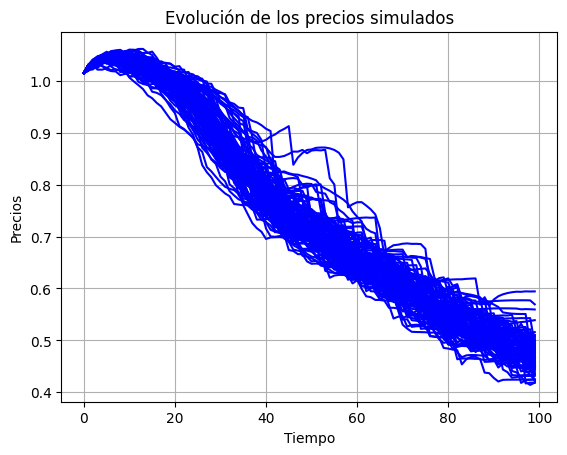

In [12]:
import matplotlib.pyplot as plt

plt.plot(sim.ntprices, color='blue')
plt.title('Evolución de los precios simulados')
plt.xlabel('Tiempo')
plt.ylabel('Precios')
plt.grid(True)
plt.show()


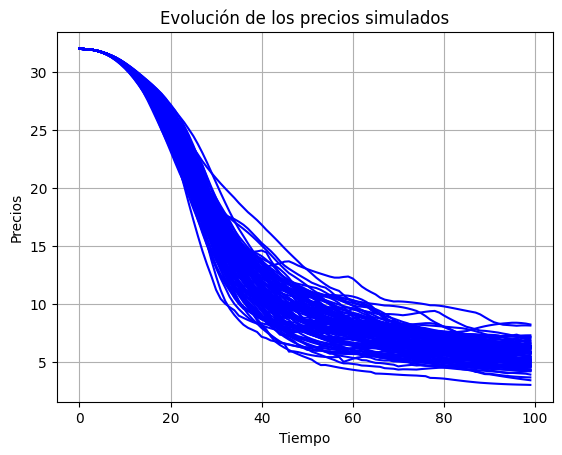

In [14]:
import matplotlib.pyplot as plt

plt.plot(sim.ntIHH, color='blue')
plt.title('Evolución de los precios simulados')
plt.xlabel('Tiempo')
plt.ylabel('Precios')
plt.grid(True)
plt.show()


In [19]:
class NW84FirmE(NW82Firm): 
    def __init__(self, A0, K0, rin, rim, beta, X0 = 0.001): 
        super().__init__(A0, K0, rin, rim) 
        self.beta = beta 
        self.X = [X0] 
        self.trajectory = [K0] 
    def update(self, Qtot, p, bank, delta ): 
        self.A = max(self.A, self.Aim, self.Ain) 
        s = self.qi/float(Qtot) 
        rho = p*self.A/float(self.c) 
        if s < 1: 
            I_d = 1+delta-float(3-2*s)/float(rho*(3-3*s)) 
        else: 
            I_d = (p-self.c)/p 
        if self.pi <= 0: 
            b = 0 
        else: 
            b=bank 
        I_p =  delta + (b+1)*self.pi 
        self.K = (1-delta+max(0, min(I_d, I_p)))*self.K 
        self.trajectory.append(self.K)
        
    def calculate_performance(self, theta): 
        self.X.append(theta*self.X[-1] + (1-theta)*self.pi)
        
    def update_policy(self, mrin, mrim, mpi): 
        if self.X[-1] < mpi and np.random.uniform(0, 1) > 0.5: 
            value_one = np.random.normal(0, 0.0004) 
            value_two = np.random.normal(0, 0.002) 
            uin = value_one if value_one > 0 else 0 
            uim = value_two if value_two > 0 else 0 
            self.rin = ((1-self.beta) * self.rin + self.beta * mrin + uin)
            self.rim = ((1-self.beta) * self.rim + self.beta * mrim + uim)
            self.X[-1] += 0.001

class NW84IndustryE(NW82Industry): 
    def __init__(self, n, K0, A0, rin, rim, Kmin = 10, Xmin = -0.051, theta = 0.25, beta = 0.167): 
        super().__init__(n, K0, A0, rin, rim) 
        self.Kmin, self.Xmin = Kmin, Xmin 
        self.theta, self.beta = theta, beta 
        self.mu, self.sigma = 0.135, 0.1177 
        self.an, self.am = 0.025, 2.5 
        self.D = 64 
        self.history = [] 
    
    def reset(self): 
        super().reset() 
        self.history = []
    
    def create(self): 
        for i in range(self.n): 
            firm = NW84FirmE(self.A0, self.K0, self.rin, self.rim, self.beta) 
            self.firms.append(firm) 
    def price(self): 
        self.Qtot = 0 
        for firm in self.firms: 
            firm.output() 
            self.Qtot += firm.qi 
        if self.Qtot < 53.33: 
            self.p = 1.20 
        else: 
            self.p = self.D/self.Qtot
    
    def update_industry(self): 
        super().update_industry() 
        self.meanA = sum(self.Alist)/len(self.firms)

    
    def update_policies(self): 
        self.mrin = sum([self.firms[i].rin for i in range(len(self.firms))])/len(self.firms) 
        self.mrim = sum([self.firms[i].rim for i in range(len(self.firms))])/len(self.firms) 
        self.mpi = sum([self.firms[i].pi for i in range(len(self.firms))])/len(self.firms) 
        for firm in self.firms: 
            firm.calculate_performance(self.theta) 
            firm.update_policy(self.mrin, self.mrim, self.mpi) 

    def remove_firms(self):
        for index, firm in enumerate(self.firms): 
            if firm.K < self.Kmin or firm.X[-1] < self.Xmin: 
                self.history.append((self.time, firm.trajectory)) 
                del self.firms[index] 

class NW84IndustryEE(NW84IndustryE): 
    def __init__(self, n, K0, A0, rin, rim, En= 2, Em = 0.2): 
        super().__init__(n, K0, A0, rin, rim) 
        self.En, self.Em = En, Em 
        self.ncount = 0 
        self.mcount = 0
    
    def entry(self): 
        imitators = np.random.poisson(self.Em * self.am) 
        innovators = np.random.poisson(self.En * self.an) 
        for i in range(imitators): 
            value = np.random.normal(0, 0.014) 
            entry_error = value if value >= 0 else 0 
            if self.p * self.b_A - 0.16 > 0.007 + entry_error: 
                value = np.random.normal(25, 7.5) 
                init_K = value if value >= self.Kmin else self.Kmin 
                firm = NW84FirmE(self.b_A, init_K, self.rin, self.rim, beta = 1) 
                self.firms.append(firm) 
                self.mcount += 1 
        for i in range(innovators): 
            value = np.random.normal(0, 0.014) 
            entry_error = value if value >= 0 else 0 
            init_A = np.exp(np.random.normal(np.log(self.mu), self.sigma)) 
            if self.p * init_A- 0.16 > 0.007 + entry_error: 
                value = np.random.normal(25, 7.5)
                init_K = value if value >= self.Kmin else self.Kmin 
                firm = NW84FirmE(init_A, init_K, self.rin, self.rim, beta = 1) 
                self.firms.append(firm) 
                self.ncount += 1

class SimNW84EE(SimNW84E): 
    def __init__(self, T =100, N= 20, n=2, K0=139.58, A0=0.16, rin=0.0287, rim=0.00143): 
        super().__init__(T, N, n, K0, A0) 
        self.nentrants = np.zeros(self.N) 
        self.mentrants = np.zeros(self.N) 
        self.mprofits = np.zeros((self.T, self.N)) 
        self.mrin = np.zeros((self.T, self.N)) 
        self.mrim = np.zeros((self.T, self.N)) 
        self.nentrants = np.zeros(self.N) 
        self.mentrants = np.zeros(self.N) 
    def simulate(self): 
        indus = NW84IndustryEE(self.n, self.K0, self.A0, self.rin, self.rim) 
        for i in range(self.N): 
            indus.reset() 
            indus.create() 
            for t in range(self.T): 
                indus.price() 
                indus.update_industry() 
                indus.update_policies() 
                indus.remove_firms() 
                indus.entry() 
                self.ntprices[t,i] = indus.p 
                self.ntb_A[t,i] = indus.b_A 
                self.ntIHH[t,i] = indus.IHH 
                self.meanA[t,i] = indus.meanA 
                self.firm_amount[t, i] = len(indus.firms) 
                self.mprofits[t, i] = indus.mpi 
                self.mrin[t, i] = indus.mrin 
                self.mrim[t, i] = indus.mrim 
            self.histories.append((i, indus.history))
            self.nentrants[i] = indus.ncount 
            self.mentrants[i] = indus.mcount

In [27]:
class NW93Industry(NW84IndustryEE): 
    def __init__(self, n, K0, A0, rin, rim): 
        super().__init__(n, K0, A0, rin, rim) 
        self.patents = {} 
        self.patent_duration = 12 
        self.best_imitable = 0 
    def reset(self): 
        super().reset() 
        self.patents = {} 
        self.best_imitable = 0 
    def update_industry(self): 
        self.mu *= self.latent 
        mux = self.mu 
        sigmax = self.sigma 
    if len(self.patents.keys()) > 0: 
        oldest = min(self.patents.keys()) 
        if (self.time - oldest == self.patent_duration + 1): 
            self.best_imitable = max(self.patents[oldest]) 
            del self.patents[oldest] 
    self.Alist = [self.firms[i].A for i in range(len(self.firms))] 
    self.Klist = [self.firms[i].K for i in range(len(self.firms))] 
    self.b_A = max(self.Alist) 
    self.meanA = np.mean(self.Alist) 
    HH = sum([k**2 for k in self.Klist])/float(sum(self.Klist)**2) 
    self.IHH = 1/float(HH) 
    for firm in self.firms: 
        firm.profit(self.p) 
        firm.innovation(self.an, mux, sigmax) 
        firm.imitation(self.am, self.best_imitable) 
        firm.update(self.Qtot, self.p, self.Bank, self.delta) 
    self.time += 1 
    for firm in self.firms: 
        if firm.A == firm.Ain: 
            if self.time in self.patents: 
                self.patents[self.time].append(firm.Ain) 
            else: 
                self.patents[self.time] = [firm.Ain] 

    def entry(self): 
        imitators = np.random.poisson(self.Em * self.am) 
        innovators = np.random.poisson(self.En * self.an) 
        for i in range(imitators): 
            value = np.random.normal(0, 0.014) 
            entry_error = value if value >= 0 else 0 
            if self.p * self.best_imitable - 0.16 > 0.007 + entry_error: 
                value = np.random.normal(25, 7.5) 
                init_K = value if value >= self.Kmin else self.Kmin 
                firm = NW84FirmE(self.best_imitable, init_K, self.rin, self.rim, beta = 1) 
                self.firms.append(firm) 
                self.mcount += 1 
        for i in range(innovators): 
            value = np.random.normal(0, 0.014) 
            entry_error = value if value >= 0 else 0
            init_A = np.exp(np.random.normal(np.log(self.mu), self.sigma)) 
            if self.p * init_A- 0.16 > 0.007 + entry_error: 
                value = np.random.normal(25, 7.5) 
                init_K = value if value >= self.Kmin else self.Kmin 
                firm = NW84FirmE(init_A, init_K, self.rin, self.rim, beta = 1) 
                self.firms.append(firm) 
                self.ncount += 1 
                if self.time in self.patents: 
                    self.patents[self.time].append(init_A) 
                else: 
                    self.patents[self.time] = [init_A]
    
    def simulate(self): 
        indus = NW93Industry(self.n, self.K0, self.A0, self.rin, self.rim) 
        for i in range(self.N): 
            indus.reset() 
            indus.create() 
            for t in range(self.T): 
                indus.price() 
                indus.update_industry() 
                indus.update_policies() 
                indus.remove_firms() 
                indus.entry() 
                self.ntprices[t,i] = indus.p 
                self.ntb_A[t,i] = indus.b_A 
                self.ntIHH[t,i] = indus.IHH 
                self.meanA[t,i] = indus.meanA 
                self.firm_amount[t, i] = len(indus.firms) 
                self.mprofits[t, i] = indus.mpi 
                self.mrin[t, i] = indus.mrin 
                self.mrim[t, i] = indus.mrim 
                self.imitable[t, i] = indus.best_imitable 
            self.histories.append((i, indus.history)) 
            self.nentrants[i] = indus.ncount 
            self.mentrants[i] = indus.mcount 

NameError: name 'self' is not defined

In [68]:
INN = np.sum(Resultados.Innov_it, axis=0)
INN2 = np.sum(Resultados2.Innov_it, axis=0)

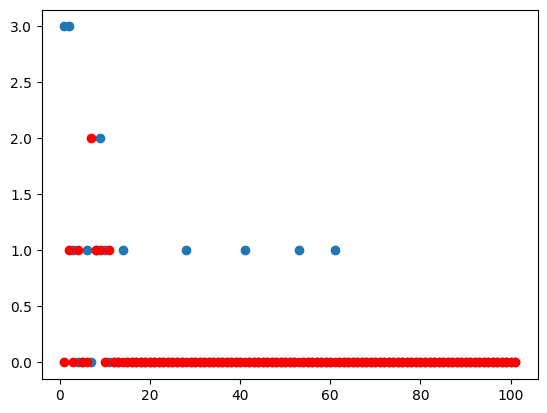

In [69]:
plt.scatter(range(1, len(INN) + 1), INN)
plt.scatter(range(1, len(INN) + 1), INN2, c= 'red')

In [70]:
from scipy.stats import kruskal

stat, p_value = kruskal(INN, INN2)

# Output the results
print(f"Kruskal-Wallis H-statistic: {stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpretation
if p_value < 0.05:
    print("There is a significant difference between the two groups.")
else:
    print("No significant difference between the two groups.")

Kruskal-Wallis H-statistic: 2.2394
P-value: 0.1345
No significant difference between the two groups.


In [63]:
Resultados.Innov_it

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])